In [115]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import matplotlib.pyplot as plt

In [116]:
def to_sequences(seq_size, obs): #Stjålet kode
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        window_target = obs[i + seq_size]
        x.append(window)
        y.append(window_target)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

# https://github.com/jeffheaton/app_deep_learning/blob/533c38d51915ed92bfbe2ddc40b3ed2054c76f18//t81_558_class_10_3_transformer_timeseries.ipynb

In [117]:
data = yf.download("EQNR", start="2000-01-01", end="2022-01-01")
data = data['Close']
data = data.reset_index()
scaler = StandardScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))
train = data[data['Date'] < pd.to_datetime('2020-01-01')]
test = data[data['Date'] >= pd.to_datetime('2020-01-01')]
data.head()


[*********************100%%**********************]  1 of 1 completed


,Date,Close
0,2001-06-18,-1.868280
1,2001-06-19,-1.846244
2,2001-06-20,-1.843305
3,2001-06-21,-1.853589
4,2001-06-22,-1.862403


In [118]:
close_train = train['Close'].to_numpy().reshape(-1, 1)
close_test = test['Close'].to_numpy().reshape(-1, 1)

In [119]:
seq_length = 10
x_train, y_train = to_sequences(seq_length, close_train)
x_test, y_test = to_sequences(seq_length, close_test)

In [120]:
# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [121]:
device = 'cpu'
model = TransformerModel().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [122]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for window, target in train_loader:
        window, target = window.to(device), target.to(device)

        optimizer.zero_grad()
        prediction = model(window)
        loss = criterion(prediction, target)

        loss.backward()
        optimizer.step()

    # Validation where we compute losses
    model.eval()
    val_losses = []
    with torch.no_grad():
        for window, target in test_loader:
            window, target = window.to(device), target.to(device)
            prediction = model(window)
            loss = criterion(prediction, target)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

Epoch 1/10, Validation Loss: 0.0158
Epoch 2/10, Validation Loss: 0.0076
Epoch 3/10, Validation Loss: 0.0208
Epoch 4/10, Validation Loss: 0.0266
Epoch 5/10, Validation Loss: 0.0102
Epoch 6/10, Validation Loss: 0.0075
Epoch 7/10, Validation Loss: 0.0109
Epoch 8/10, Validation Loss: 0.0161
Epoch 9/10, Validation Loss: 0.0071
Epoch 10/10, Validation Loss: 0.0073


In [123]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 0.5804


In [124]:
predictions = np.squeeze(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)))
y_test_plot = np.squeeze(scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))

In [125]:
y_train_plot = np.squeeze(scaler.inverse_transform(y_train.numpy().reshape(-1, 1)))

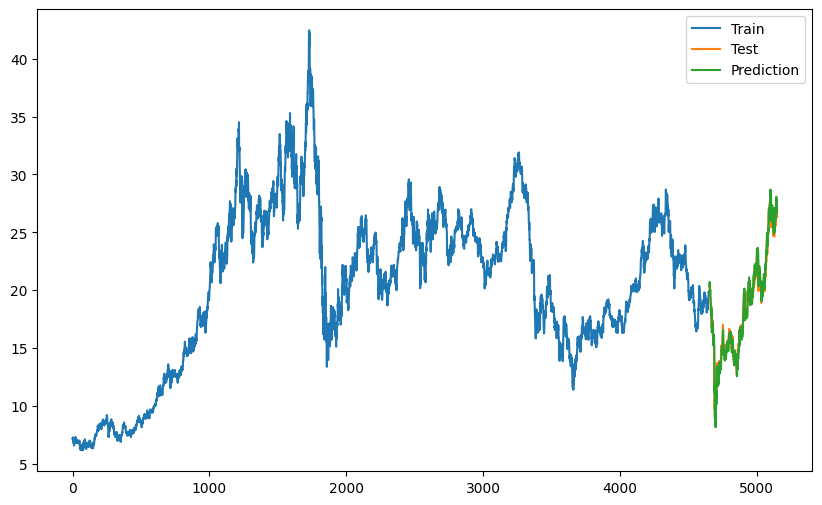

In [126]:
x = np.arange(len(y_train_plot)+len(y_test_plot))

plt.figure(figsize=(10, 6))
plt.plot(x[:len(y_train_plot)], y_train_plot, label='Train')
plt.plot(x[len(y_train_plot):], y_test_plot, label='Test')
plt.plot(x[len(y_train_plot):], predictions, label='Prediction')
plt.legend()
plt.show()

In [127]:
print(x_test[0])

tensor([[ 0.0356],
        [ 0.0445],
        [ 0.1135],
        [ 0.0782],
        [ 0.0547],
        [ 0.0709],
        [ 0.0371],
        [ 0.0445],
        [ 0.0356],
        [-0.0114]])


In [128]:
days = 20#len(y_test)
#multistep predictions
seq = x_test[0].unsqueeze(0)
preds = x_test[0].unsqueeze(0)
print(seq.shape)
model.eval()
for i in range(days):
  pred = model(seq)
  preds = torch.cat((preds, pred.unsqueeze(0)), dim=1)
  seq = torch.cat((seq[:, 1:], pred.unsqueeze(0)), dim=1)

torch.Size([1, 10, 1])


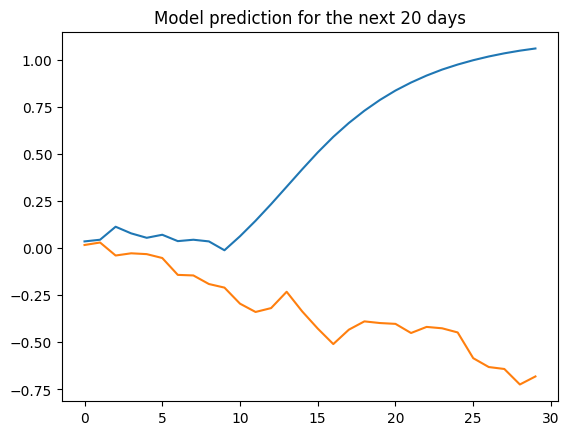

In [129]:
plt.plot(preds.squeeze(0).detach().numpy())
plt.plot(y_test.squeeze(0).detach().numpy()[0:len(preds.squeeze(0))])
plt.title(f'Model prediction for the next {days} days')
plt.show()